In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn import metrics

def load_csv(file, describe=False):
    df = pd.read_csv(file, na_values='NA')
    df = df.drop(['id', 'Unnamed: 0'], axis=1) # Dropping the ID column
    
    # Display basic information
    df.info()
    if describe:
        print(df.describe(include='all'))

    X = df.drop(['loss'], axis=1) # Features
    y = (df.loc[:,'loss'] > 0) # Labels
    if describe:
        print(X.shape, y.shape)
    
    return df, X, y


def split_data(kf, X, y, describe=False): 
    splits = list(kf.split(X))
    train_index, valid_index = splits[0] # Take the first split only    
    if describe:
        print("Training set: ", train_index)
        print("Validation set: ", valid_index)
    
    X_train, X_valid = X.iloc[train_index, :], X.iloc[valid_index, :]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    return X_train, y_train, X_valid, y_valid
def train_model(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    fit_time = end - start
    print('Time elapsed (Training): %.4f s' % fit_time)
    print(clf)

    return fit_time


def evaluate (clf, X_train, y_train, X_valid, y_valid, plot=True):
    # Plotting ROCAUC and PRAUC
    f, (plt1, plt2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))        
    plt1.set_title('ROC Curve')
    plt1.set_xlabel('FPR')
    plt1.set_ylabel('TPR')
    plt2.set_title('PR Curve')
    plt2.set_xlabel('Precision')
    plt2.set_ylabel('Recall')

    start = time.time()

    # Training set    
    y_train_predicted = clf.predict_proba(X_train)
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_predicted[:,1])
    precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_train_predicted[:,1])
    plt1.scatter(fpr, tpr, color='b')    
    plt2.scatter(precision, recall,color='b')
    print('Accuracy (Training): %f' % clf.score(X_train, y_train))
    print('ROCAUC Score (Training): %f' % metrics.roc_auc_score(y_train, y_train_predicted[:,1]))
    

# Validation set
    y_valid_predicted = clf.predict_proba(X_valid)    
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_valid_predicted[:,1])
    precision, recall, thresholds = metrics.precision_recall_curve(y_valid, y_valid_predicted[:,1])
    plt1.scatter(fpr, tpr, color='r')
    plt2.scatter(precision, recall,color='r')
    acc_score = clf.score(X_valid, y_valid)
    print('Accuracy (Validation): %f' % acc_score)
    rocauc_score = metrics.roc_auc_score(y_valid, y_valid_predicted[:,1])
    print('ROCAUC Score (Validation): %f' % rocauc_score)
   
    

    end = time.time()
    eval_time = end - start
    print('Time elapsed (Evaluation): %.4f s' % eval_time)

    if plot:
        plt.show()
    plt.close()
    
    return acc_score, rocauc_score, eval_time

def plot_metrics (var_s, var_name, is_float, fit_times, eval_times, acc_scores, rocauc_scores):
    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color='black', label='Fitting Time'), 
               mpatches.Patch(color='blue', label='Evaluation Time')]
    plt.xlabel(var_name)
    plt.ylabel('Model Fitting/Evaluation Time (s)')
    plt.legend(handles=patches)
    plt.scatter(var_s, fit_times, color='black')
    plt.scatter(var_s, eval_times, color='blue')
    plt.show()

    patches = [mpatches.Patch(color='blue', label='Accuracy'), 
               mpatches.Patch(color='green', label='ROCAUC'), 
               ]
    plt.xlabel(var_name)
    plt.ylabel('Metrics')
    plt.legend(handles=patches)
    plt.scatter(var_s, acc_scores, color='blue')
    plt.scatter(var_s, rocauc_scores, color='green')
    
    plt.show()

    results = pd.DataFrame({'0_' + var_name: var_s, '1_Accuracy': acc_scores, '2_ROCAUC': rocauc_scores,  '4_fit_time': fit_times, '5_eval_time': eval_times})
    print(results)
    print('\n')
    print(results.describe())
    print('\n')
    if is_float:
        print('Best accuracy score=%f, at %s=%f' % (max(acc_scores), var_name, var_s[acc_scores.index(max(acc_scores))]))
        print('Best ROCAUC score=%f, at %s=%f' % (max(rocauc_scores), var_name, var_s[rocauc_scores.index(max(rocauc_scores))]))
        
    else:
        print('Best accuracy score=%f, at %s=%d' % (max(acc_scores), var_name, var_s[acc_scores.index(max(acc_scores))]))
        print('Best ROCAUC score=%f, at %s=%d' % (max(rocauc_scores), var_name, var_s[rocauc_scores.index(max(rocauc_scores))]))
       


In [20]:
# Load the training data (imputed but not normalized) from the CSV file

df, X, y = load_csv('/content/drive/MyDrive/Colab Notebooks/train_v2_preprocessed.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f1_x0_103 to loss
dtypes: float64(1736), int64(53)
memory usage: 1.4 GB


In [21]:

# Separate training and validation sets

from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
X_train, y_train, X_valid, y_valid =split_data(kf, X, y)

Time elapsed (Training): 270.0236 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.645588
Time elapsed (Evaluation): 16.2153 s


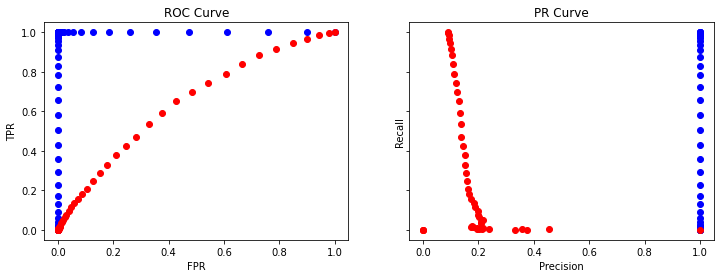

In [ ]:
from sklearn import ensemble

clf = ensemble.RandomForestClassifier()
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score,  eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f3 to loss
dtypes: float64(1788), int64(1)
memory usage: 1.4 GB
Time elapsed (Training): 271.6761 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy (Training): 0.999976
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.640069
Time elapsed (Evaluation): 15.6602 s


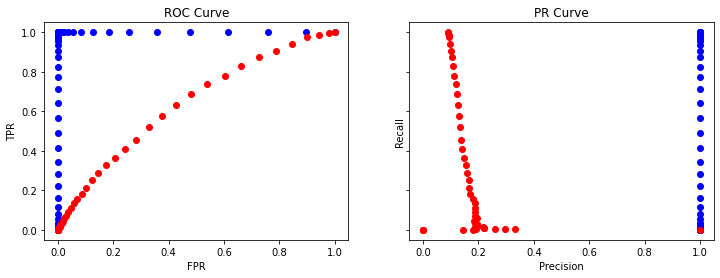

In [22]:
# Load the training data (imputed and normalized) from the CSV file
df, X, y = load_csv('/content/drive/MyDrive/Colab Notebooks/train_v2_preprocessed_normalized.csv')

# Separate training and validation sets
X_train, y_train, X_valid, y_valid = split_data(kf, X, y)

# Train the model and evaluate
clf = ensemble.RandomForestClassifier()
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score, eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

Time elapsed (Training): 190.1531 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.999976
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.653494
Time elapsed (Evaluation): 13.0105 s


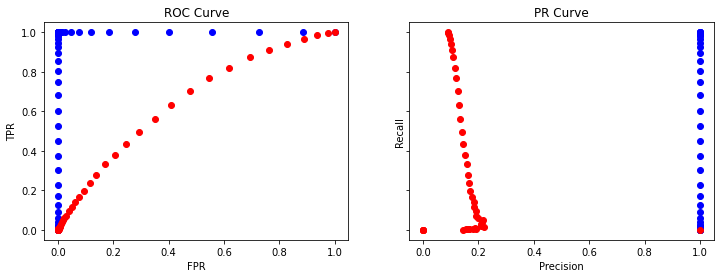

In [ ]:

# Define weights for unbalanced classes

class_weight = {0: 1., 1: 10.}
clf = ensemble.RandomForestClassifier(class_weight=class_weight)
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score,  eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

----- k = 1 -----
Time elapsed (Training): 11.7532 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=1, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.522068
ROCAUC Score (Training): 0.645970
Accuracy (Validation): 0.521688
ROCAUC Score (Validation): 0.646788
Time elapsed (Evaluation): 2.1259 s


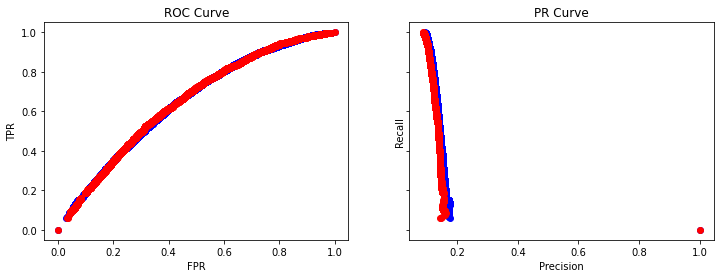

----- k = 2 -----
Time elapsed (Training): 22.3955 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.545119
ROCAUC Score (Training): 0.656107
Accuracy (Validation): 0.548092
ROCAUC Score (Validation): 0.654790
Time elapsed (Evaluation): 2.3242 s


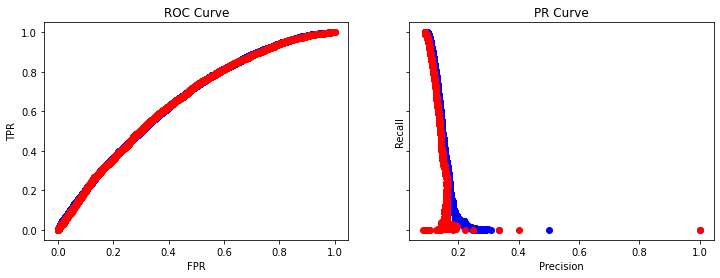

----- k = 3 -----
Time elapsed (Training): 33.5181 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.548450
ROCAUC Score (Training): 0.665761
Accuracy (Validation): 0.556293
ROCAUC Score (Validation): 0.659475
Time elapsed (Evaluation): 2.5373 s


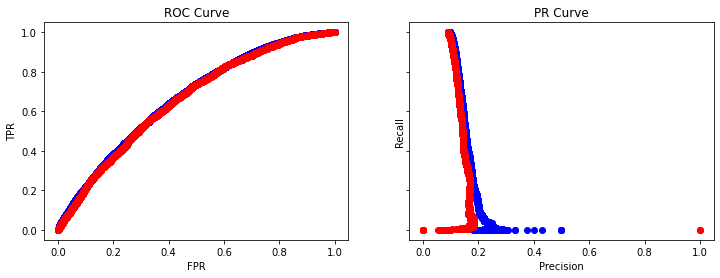

----- k = 4 -----
Time elapsed (Training): 43.5947 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.552420
ROCAUC Score (Training): 0.678197
Accuracy (Validation): 0.556720
ROCAUC Score (Validation): 0.665665
Time elapsed (Evaluation): 2.6907 s


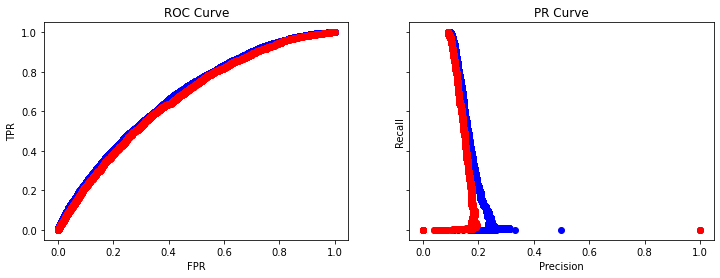

----- k = 5 -----
Time elapsed (Training): 54.7674 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.562719
ROCAUC Score (Training): 0.689739
Accuracy (Validation): 0.567623
ROCAUC Score (Validation): 0.667313
Time elapsed (Evaluation): 3.0384 s


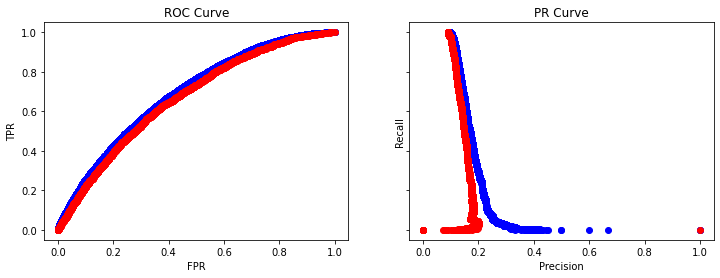

----- k = 6 -----
Time elapsed (Training): 65.0614 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.590286
ROCAUC Score (Training): 0.710346
Accuracy (Validation): 0.588907
ROCAUC Score (Validation): 0.669817
Time elapsed (Evaluation): 3.8318 s


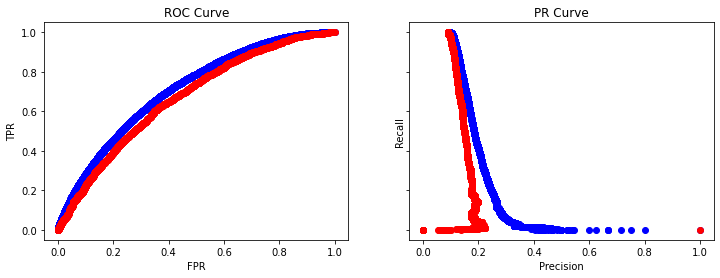

----- k = 7 -----
Time elapsed (Training): 75.6751 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.618636
ROCAUC Score (Training): 0.736823
Accuracy (Validation): 0.611519
ROCAUC Score (Validation): 0.671375
Time elapsed (Evaluation): 4.3338 s


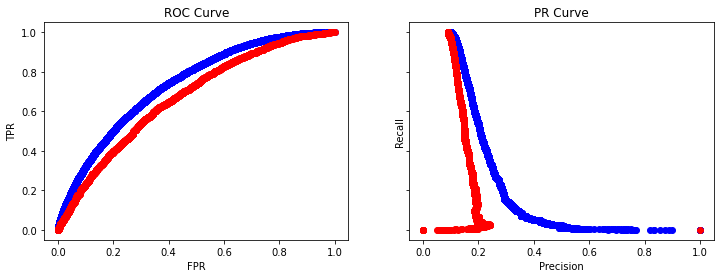

----- k = 8 -----
Time elapsed (Training): 85.7496 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.657888
ROCAUC Score (Training): 0.772865
Accuracy (Validation): 0.638587
ROCAUC Score (Validation): 0.674035
Time elapsed (Evaluation): 4.8082 s


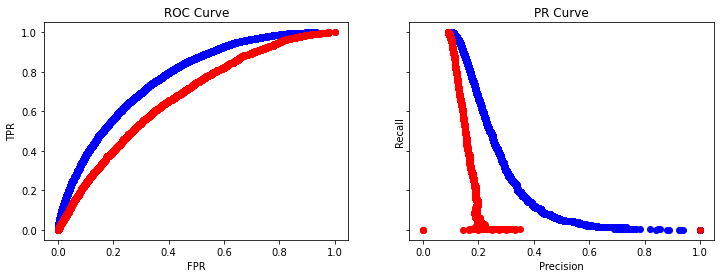

----- k = 9 -----
Time elapsed (Training): 95.6971 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.707014
ROCAUC Score (Training): 0.816560
Accuracy (Validation): 0.673382
ROCAUC Score (Validation): 0.673146
Time elapsed (Evaluation): 5.3373 s


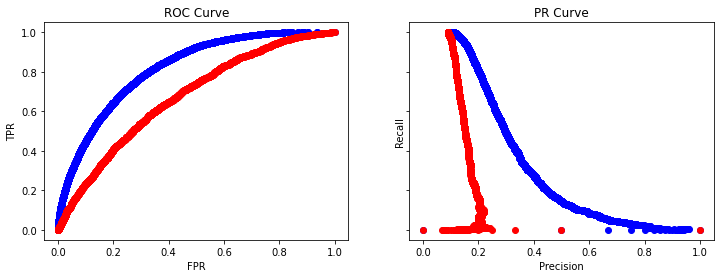

----- k = 10 -----
Time elapsed (Training): 106.1130 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.763072
ROCAUC Score (Training): 0.865895
Accuracy (Validation): 0.716615
ROCAUC Score (Validation): 0.673505
Time elapsed (Evaluation): 6.0507 s


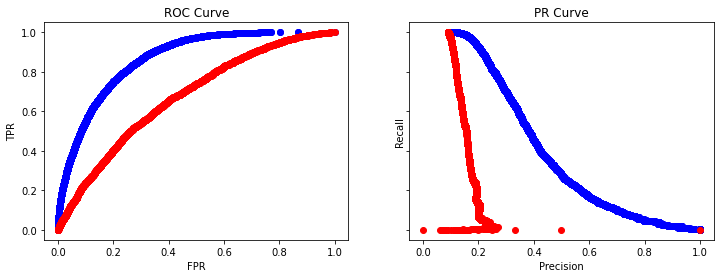

----- k = 11 -----
Time elapsed (Training): 115.8992 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.813928
ROCAUC Score (Training): 0.907323
Accuracy (Validation): 0.749135
ROCAUC Score (Validation): 0.673635
Time elapsed (Evaluation): 6.6813 s


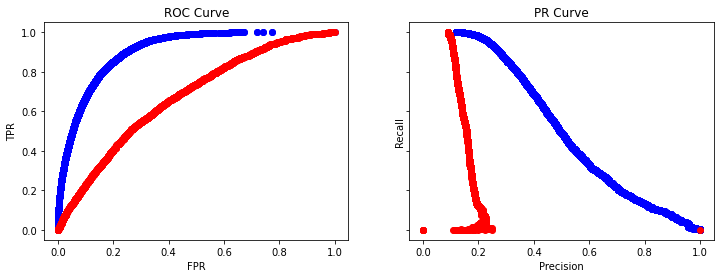

----- k = 12 -----
Time elapsed (Training): 125.1234 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.853145
ROCAUC Score (Training): 0.938915
Accuracy (Validation): 0.774070
ROCAUC Score (Validation): 0.670497
Time elapsed (Evaluation): 7.2510 s


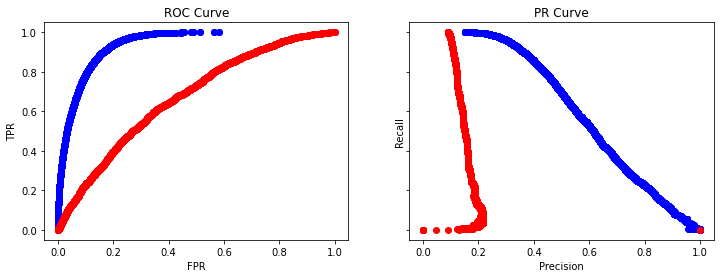

----- k = 13 -----
Time elapsed (Training): 131.4760 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=13, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.899640
ROCAUC Score (Training): 0.967175
Accuracy (Validation): 0.807632
ROCAUC Score (Validation): 0.670370
Time elapsed (Evaluation): 7.8840 s


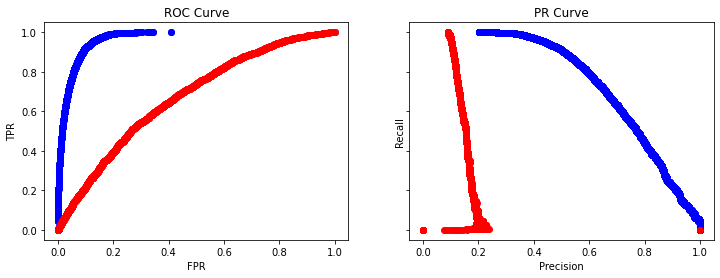

----- k = 14 -----
Time elapsed (Training): 138.9712 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.924991
ROCAUC Score (Training): 0.982204
Accuracy (Validation): 0.832946
ROCAUC Score (Validation): 0.671723
Time elapsed (Evaluation): 8.4533 s


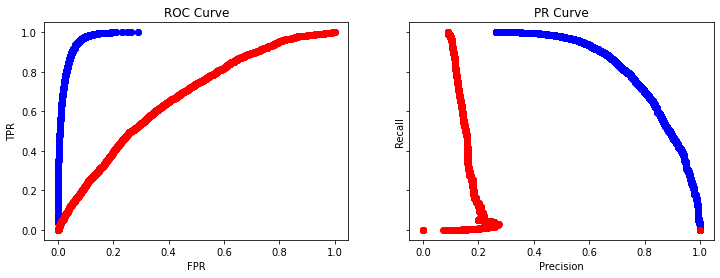

----- k = 15 -----
Time elapsed (Training): 145.5887 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.952001
ROCAUC Score (Training): 0.992187
Accuracy (Validation): 0.853946
ROCAUC Score (Validation): 0.670790
Time elapsed (Evaluation): 9.0705 s


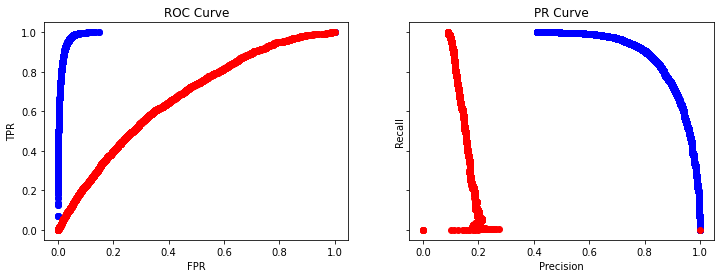

In [ ]:
#max depth
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for k in ks:
    print('----- k = %d -----' % k)
    clf = ensemble.RandomForestClassifier(class_weight=class_weight, max_depth=k)
    fit_time =train_model(clf, X_train, y_train)
    acc_score, rocauc_score, eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score)

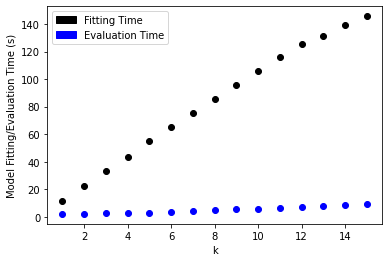

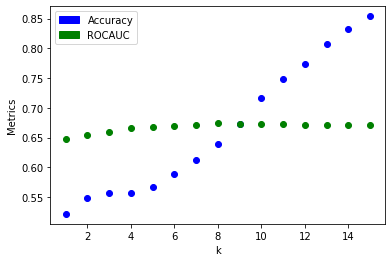

    0_k  1_Accuracy  2_ROCAUC  4_fit_time  5_eval_time
0     1    0.521688  0.646788   11.753162     2.125910
1     2    0.548092  0.654790   22.395533     2.324203
2     3    0.556293  0.659475   33.518054     2.537338
3     4    0.556720  0.665665   43.594651     2.690700
4     5    0.567623  0.667313   54.767419     3.038441
5     6    0.588907  0.669817   65.061395     3.831848
6     7    0.611519  0.671375   75.675092     4.333837
7     8    0.638587  0.674035   85.749568     4.808179
8     9    0.673382  0.673146   95.697056     5.337282
9    10    0.716615  0.673505  106.112958     6.050719
10   11    0.749135  0.673635  115.899197     6.681279
11   12    0.774070  0.670497  125.123425     7.250958
12   13    0.807632  0.670370  131.476046     7.883985
13   14    0.832946  0.671723  138.971153     8.453275
14   15    0.853946  0.670790  145.588653     9.070507


             0_k  1_Accuracy   2_ROCAUC  4_fit_time  5_eval_time
count  15.000000   15.000000  15.000000   15.000000  

In [ ]:
plot_metrics(ks, 'k', False, fit_times, eval_times, acc_scores, rocauc_scores)

----- k = 2 -----
Time elapsed (Training): 198.5281 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.999988
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.653381
Time elapsed (Evaluation): 13.4073 s


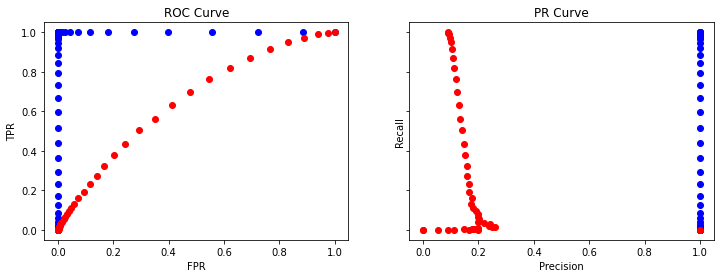

----- k = 5 -----
Time elapsed (Training): 190.9592 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.999964
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.654608
Time elapsed (Evaluation): 13.0435 s


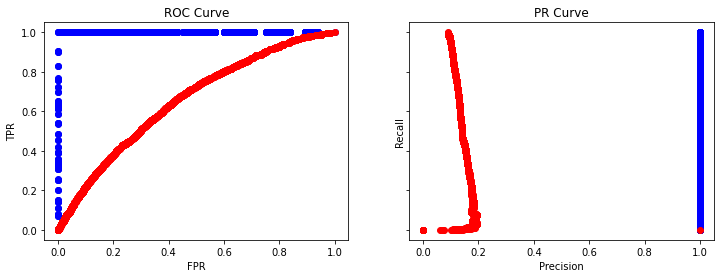

----- k = 10 -----
Time elapsed (Training): 189.2227 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.999881
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.657911
Time elapsed (Evaluation): 12.7206 s


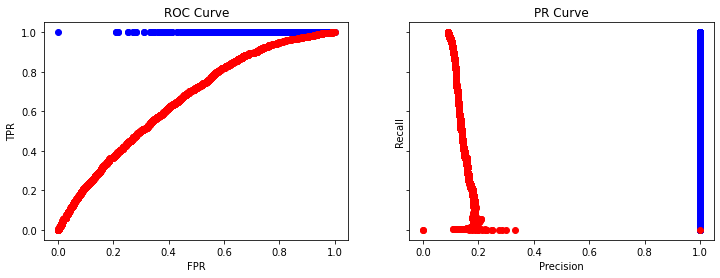

----- k = 20 -----
Time elapsed (Training): 186.0407 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=20, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.999170
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.911780
ROCAUC Score (Validation): 0.659646
Time elapsed (Evaluation): 12.4236 s


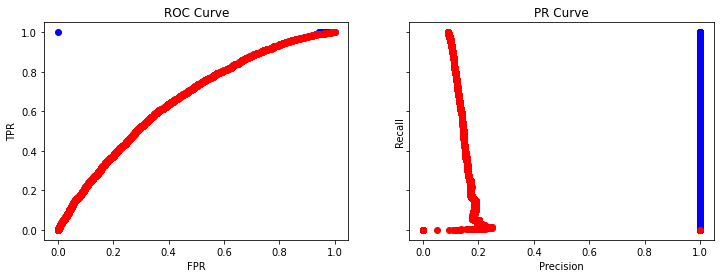

----- k = 50 -----
Time elapsed (Training): 172.3061 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=50, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.995034
ROCAUC Score (Training): 0.999860
Accuracy (Validation): 0.908983
ROCAUC Score (Validation): 0.667674
Time elapsed (Evaluation): 11.1616 s


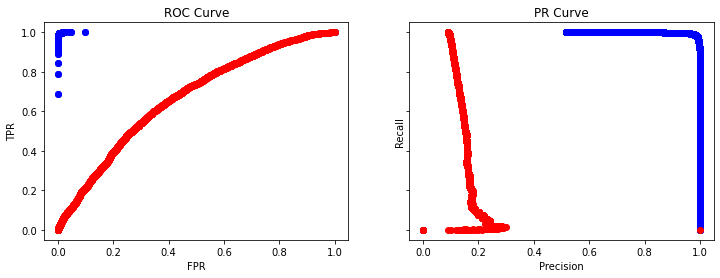

----- k = 100 -----
Time elapsed (Training): 157.7682 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=100, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.971686
ROCAUC Score (Training): 0.990513
Accuracy (Validation): 0.877080
ROCAUC Score (Validation): 0.670495
Time elapsed (Evaluation): 9.8034 s


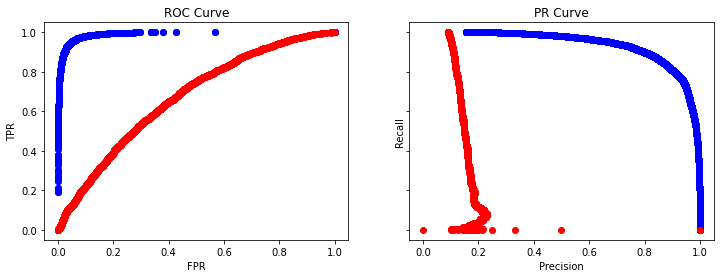

----- k = 200 -----
Time elapsed (Training): 145.0518 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=200, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.874396
ROCAUC Score (Training): 0.932009
Accuracy (Validation): 0.798862
ROCAUC Score (Validation): 0.675425
Time elapsed (Evaluation): 8.3826 s


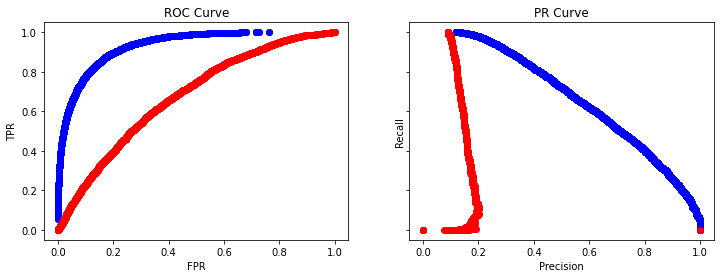

----- k = 500 -----
Time elapsed (Training): 122.2644 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=500, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.726439
ROCAUC Score (Training): 0.821441
Accuracy (Validation): 0.694193
ROCAUC Score (Validation): 0.678221
Time elapsed (Evaluation): 6.4075 s


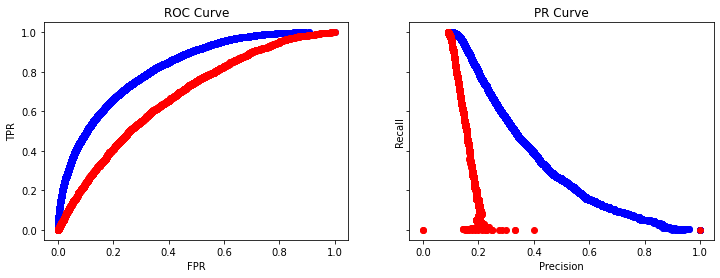

----- k = 1000 -----
Time elapsed (Training): 102.9819 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=1000, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.647020
ROCAUC Score (Training): 0.759339
Accuracy (Validation): 0.634558
ROCAUC Score (Validation): 0.675366
Time elapsed (Evaluation): 5.2259 s


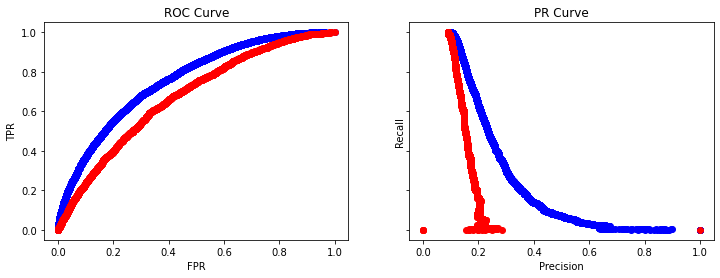

----- k = 2000 -----
Time elapsed (Training): 80.0442 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2000, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.598701
ROCAUC Score (Training): 0.717326
Accuracy (Validation): 0.597298
ROCAUC Score (Validation): 0.674615
Time elapsed (Evaluation): 4.3055 s


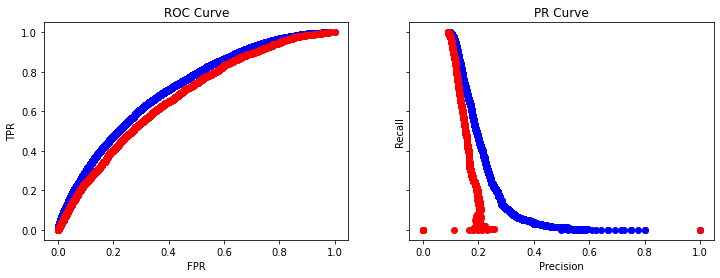

----- k = 5000 -----
Time elapsed (Training): 54.7796 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5000, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.563027
ROCAUC Score (Training): 0.684074
Accuracy (Validation): 0.569708
ROCAUC Score (Validation): 0.668227
Time elapsed (Evaluation): 2.8970 s


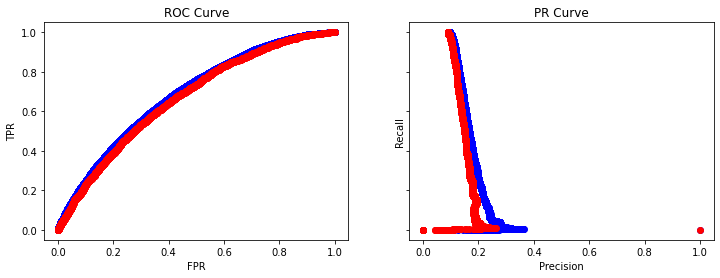

In [ ]:
#min samples split
ks = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []

for k in ks:
    print('----- k = %d -----' % k)
    clf = ensemble.RandomForestClassifier(class_weight=class_weight, min_samples_split=k)
    fit_time = train_model(clf, X_train, y_train)
    acc_score, rocauc_score,  eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score)

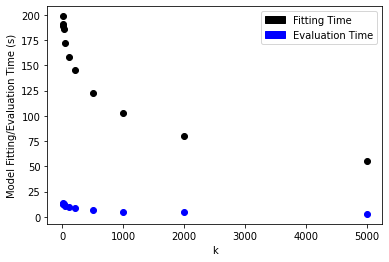

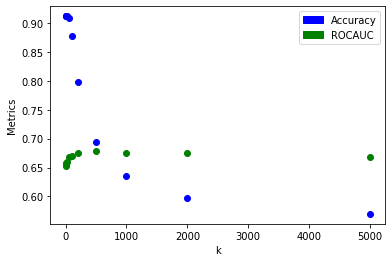

     0_k  1_Accuracy  2_ROCAUC  4_fit_time  5_eval_time
0      2    0.911827  0.653381  198.528114    13.407295
1      5    0.911827  0.654608  190.959246    13.043480
2     10    0.911827  0.657911  189.222709    12.720560
3     20    0.911780  0.659646  186.040720    12.423577
4     50    0.908983  0.667674  172.306051    11.161613
5    100    0.877080  0.670495  157.768153     9.803437
6    200    0.798862  0.675425  145.051761     8.382562
7    500    0.694193  0.678221  122.264421     6.407508
8   1000    0.634558  0.675366  102.981945     5.225941
9   2000    0.597298  0.674615   80.044248     4.305485
10  5000    0.569708  0.668227   54.779639     2.897017


               0_k  1_Accuracy   2_ROCAUC  4_fit_time  5_eval_time
count    11.000000   11.000000  11.000000   11.000000    11.000000
mean    807.909091    0.793450   0.666870  145.449728     9.070770
std    1520.629505    0.141438   0.009025   49.158225     3.837070
min       2.000000    0.569708   0.653381   54.779639     

In [ ]:
plot_metrics(ks, 'k', False, fit_times, eval_times, acc_scores, rocauc_scores)

----- k = 1 -----
Time elapsed (Training): 191.4423 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.999893
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.655555
Time elapsed (Evaluation): 13.1626 s


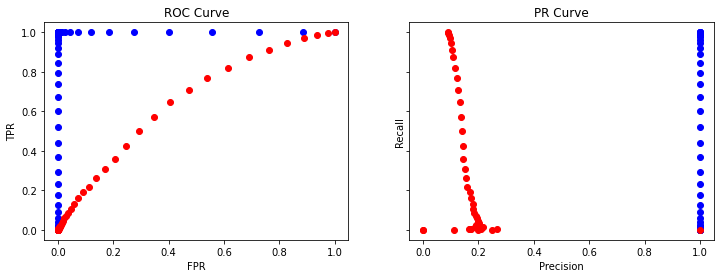

----- k = 2 -----
Time elapsed (Training): 182.6137 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.999953
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.656538
Time elapsed (Evaluation): 12.3024 s


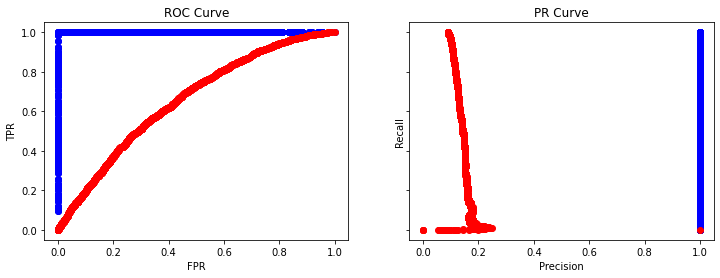

----- k = 5 -----
Time elapsed (Training): 173.2131 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.999490
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.911685
ROCAUC Score (Validation): 0.671477
Time elapsed (Evaluation): 11.5797 s


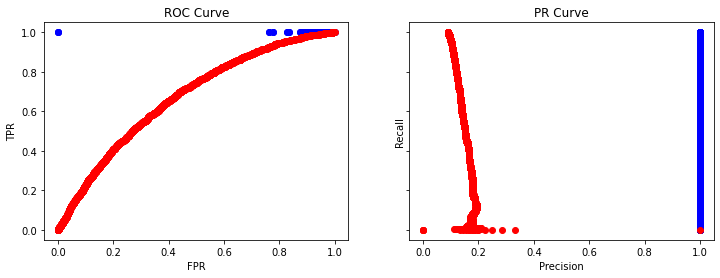

----- k = 10 -----
Time elapsed (Training): 164.1826 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.997227
ROCAUC Score (Training): 0.999959
Accuracy (Validation): 0.909457
ROCAUC Score (Validation): 0.674927
Time elapsed (Evaluation): 10.6604 s


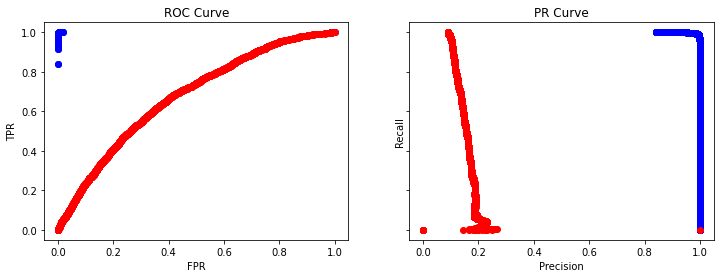

----- k = 20 -----
Time elapsed (Training): 153.6524 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.977043
ROCAUC Score (Training): 0.994073
Accuracy (Validation): 0.882911
ROCAUC Score (Validation): 0.676308
Time elapsed (Evaluation): 9.7436 s


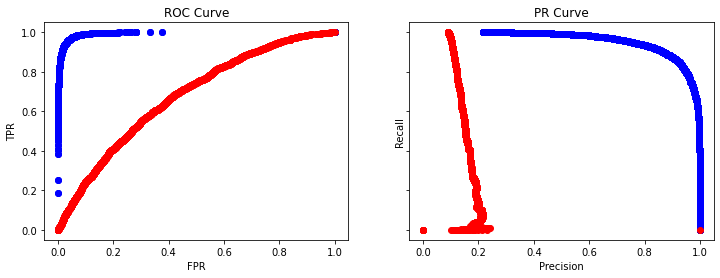

----- k = 50 -----
Time elapsed (Training): 130.1484 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=50,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.858645
ROCAUC Score (Training): 0.925036
Accuracy (Validation): 0.789239
ROCAUC Score (Validation): 0.675673
Time elapsed (Evaluation): 8.1046 s


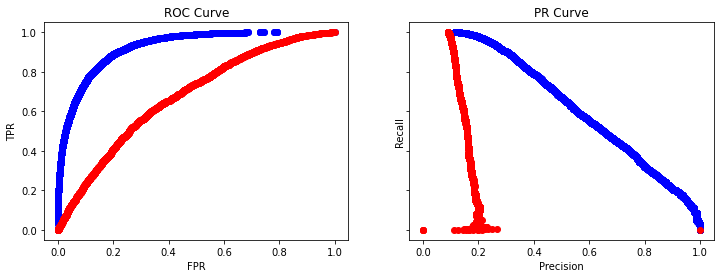

----- k = 100 -----
Time elapsed (Training): 112.2077 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=100,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.741206
ROCAUC Score (Training): 0.836270
Accuracy (Validation): 0.707324
ROCAUC Score (Validation): 0.675462
Time elapsed (Evaluation): 6.8603 s


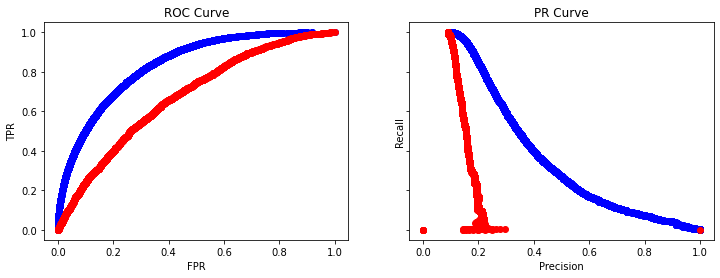

----- k = 200 -----
Time elapsed (Training): 95.0282 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=200,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.657142
ROCAUC Score (Training): 0.765979
Accuracy (Validation): 0.643517
ROCAUC Score (Validation): 0.675607
Time elapsed (Evaluation): 5.7304 s


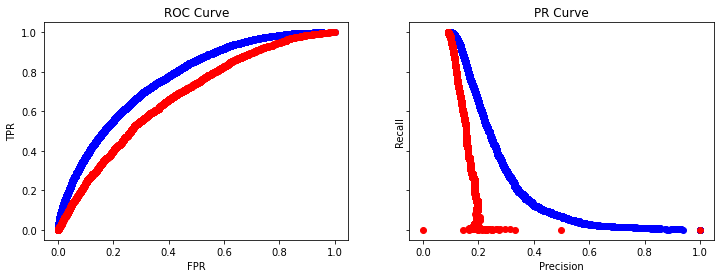

----- k = 500 -----
Time elapsed (Training): 75.7096 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=500,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.594162
ROCAUC Score (Training): 0.713767
Accuracy (Validation): 0.593885
ROCAUC Score (Validation): 0.672970
Time elapsed (Evaluation): 4.5910 s


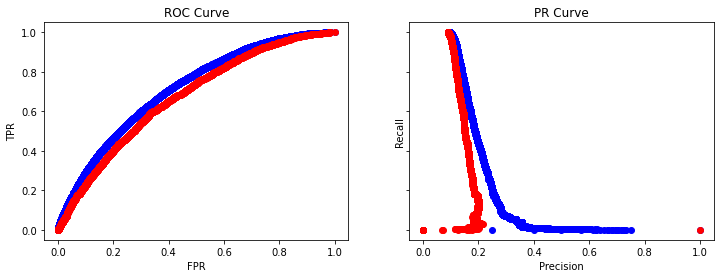

----- k = 1000 -----
Time elapsed (Training): 64.4925 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1000,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.568088
ROCAUC Score (Training): 0.691099
Accuracy (Validation): 0.572458
ROCAUC Score (Validation): 0.668225
Time elapsed (Evaluation): 3.9604 s


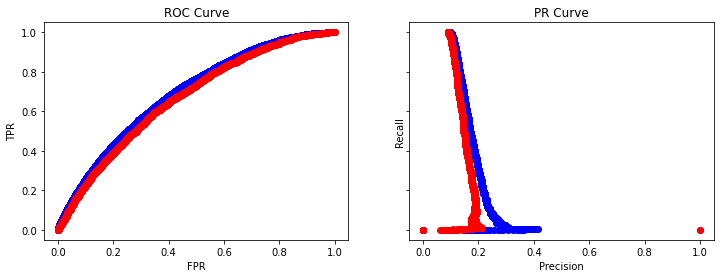

----- k = 2000 -----
Time elapsed (Training): 49.1006 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2000,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.561001
ROCAUC Score (Training): 0.679794
Accuracy (Validation): 0.567812
ROCAUC Score (Validation): 0.666838
Time elapsed (Evaluation): 2.8965 s


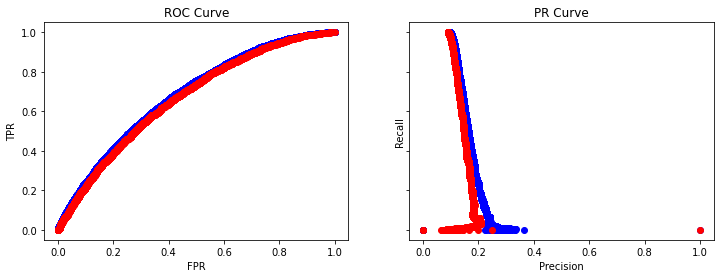

----- k = 5000 -----
Time elapsed (Training): 32.4820 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5000,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.554518
ROCAUC Score (Training): 0.665508
Accuracy (Validation): 0.559706
ROCAUC Score (Validation): 0.660097
Time elapsed (Evaluation): 2.5813 s


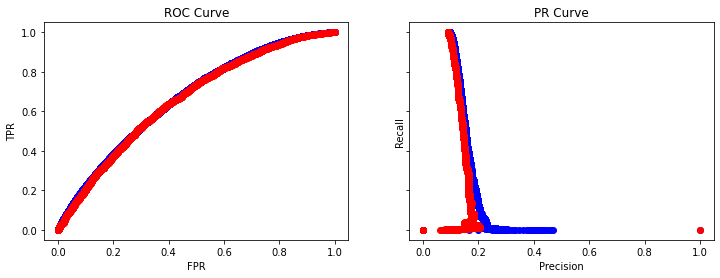

In [23]:
#min samples leaf
ks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []

for k in ks:
    print('----- k = %d -----' % k)
    clf = ensemble.RandomForestClassifier(class_weight=class_weight, min_samples_leaf=k)
    fit_time = train_model(clf, X_train, y_train)
    acc_score, rocauc_score,  eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score)

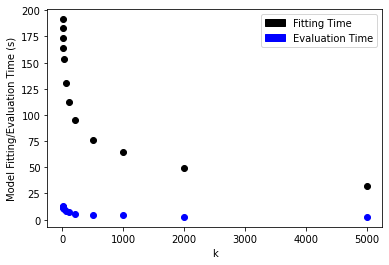

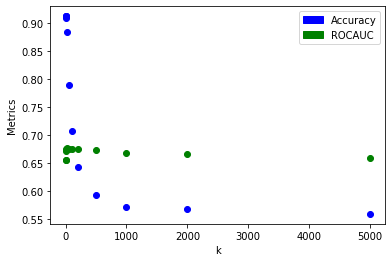

     0_k  1_Accuracy  2_ROCAUC  4_fit_time  5_eval_time
0      1    0.911827  0.655555  191.442304    13.162647
1      2    0.911827  0.656538  182.613689    12.302438
2      5    0.911685  0.671477  173.213108    11.579671
3     10    0.909457  0.674927  164.182596    10.660399
4     20    0.882911  0.676308  153.652402     9.743592
5     50    0.789239  0.675673  130.148444     8.104613
6    100    0.707324  0.675462  112.207716     6.860273
7    200    0.643517  0.675607   95.028161     5.730361
8    500    0.593885  0.672970   75.709599     4.590992
9   1000    0.572458  0.668225   64.492488     3.960385
10  2000    0.567812  0.666838   49.100645     2.896503
11  5000    0.559706  0.660097   32.482003     2.581273


               0_k  1_Accuracy   2_ROCAUC  4_fit_time  5_eval_time
count    12.000000   12.000000  12.000000   12.000000    12.000000
mean    740.666667    0.746804   0.669140  118.689430     7.681096
std    1468.455734    0.154179   0.007750   55.133088     3.774131
mi

In [24]:
plot_metrics(ks, 'k', False, fit_times, eval_times, acc_scores, rocauc_scores)

----- k = 2 -----
Time elapsed (Training): 23.3069 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=2,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.536800
ROCAUC Score (Training): 0.645327
Accuracy (Validation): 0.533397
ROCAUC Score (Validation): 0.646377
Time elapsed (Evaluation): 2.2171 s


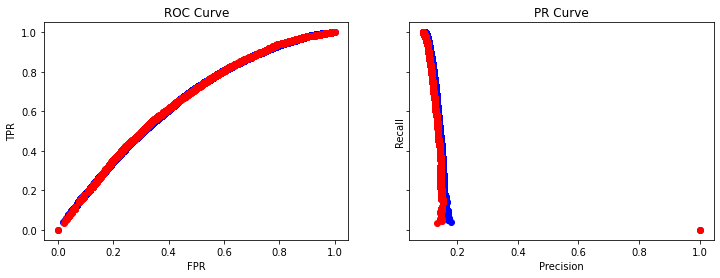

----- k = 5 -----
Time elapsed (Training): 37.0178 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=5,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.533268
ROCAUC Score (Training): 0.659680
Accuracy (Validation): 0.535956
ROCAUC Score (Validation): 0.657194
Time elapsed (Evaluation): 2.3842 s


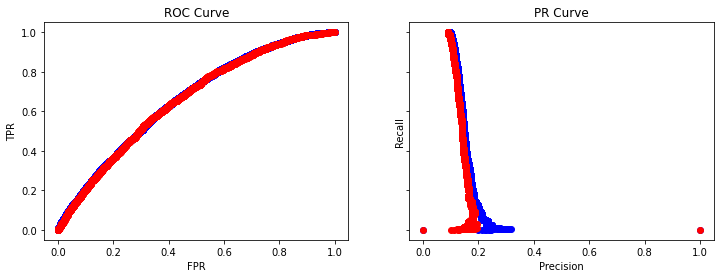

----- k = 10 -----
Time elapsed (Training): 48.6177 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=10,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.541102
ROCAUC Score (Training): 0.671445
Accuracy (Validation): 0.545248
ROCAUC Score (Validation): 0.663111
Time elapsed (Evaluation): 2.5911 s


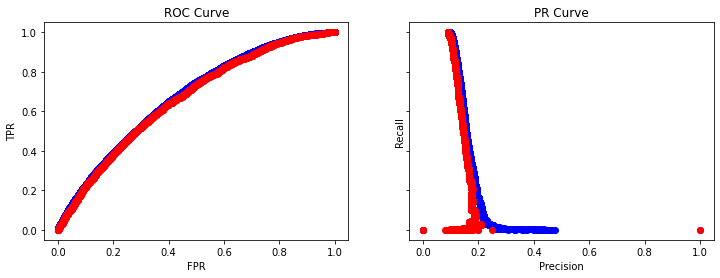

----- k = 20 -----
Time elapsed (Training): 60.7707 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=20,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.554707
ROCAUC Score (Training): 0.683103
Accuracy (Validation): 0.560891
ROCAUC Score (Validation): 0.666770
Time elapsed (Evaluation): 2.8062 s


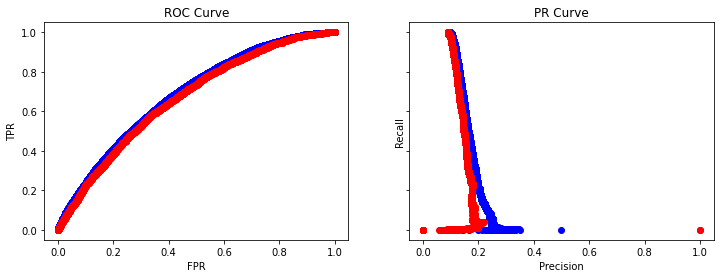

----- k = 50 -----
Time elapsed (Training): 77.1890 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=50,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.581753
ROCAUC Score (Training): 0.709064
Accuracy (Validation): 0.580801
ROCAUC Score (Validation): 0.671618
Time elapsed (Evaluation): 3.9103 s


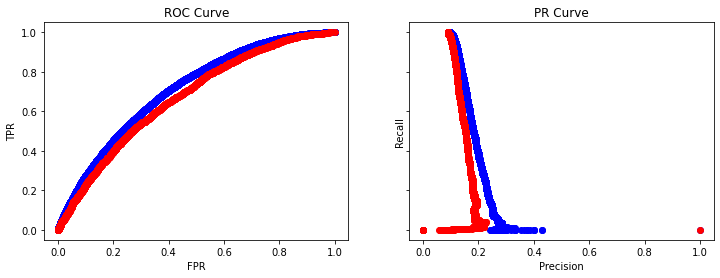

----- k = 100 -----
Time elapsed (Training): 90.5000 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=100,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.623447
ROCAUC Score (Training): 0.742384
Accuracy (Validation): 0.614885
ROCAUC Score (Validation): 0.673428
Time elapsed (Evaluation): 4.4691 s


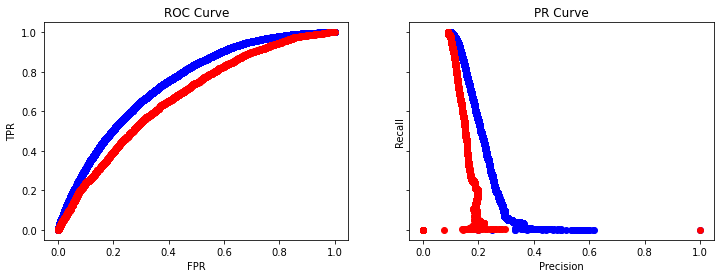

----- k = 200 -----
Time elapsed (Training): 105.3651 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=200,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.687376
ROCAUC Score (Training): 0.794658
Accuracy (Validation): 0.663238
ROCAUC Score (Validation): 0.673405
Time elapsed (Evaluation): 5.2057 s


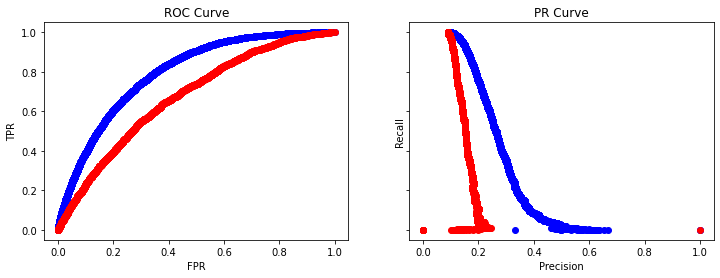

----- k = 500 -----
Time elapsed (Training): 131.4269 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=500,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.823658
ROCAUC Score (Training): 0.900384
Accuracy (Validation): 0.762361
ROCAUC Score (Validation): 0.675098
Time elapsed (Evaluation): 6.8483 s


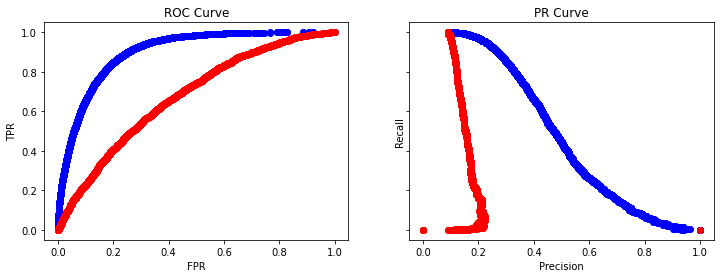

----- k = 1000 -----
Time elapsed (Training): 150.0997 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=1000,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.935764
ROCAUC Score (Training): 0.976900
Accuracy (Validation): 0.849585
ROCAUC Score (Validation): 0.677361
Time elapsed (Evaluation): 8.3482 s


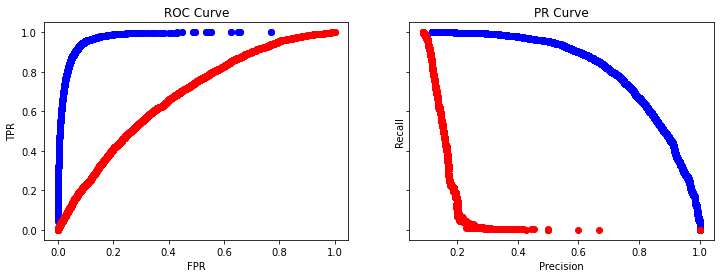

----- k = 2000 -----
Time elapsed (Training): 166.9940 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=2000,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.995816
ROCAUC Score (Training): 0.999675
Accuracy (Validation): 0.903342
ROCAUC Score (Validation): 0.667392
Time elapsed (Evaluation): 10.1541 s


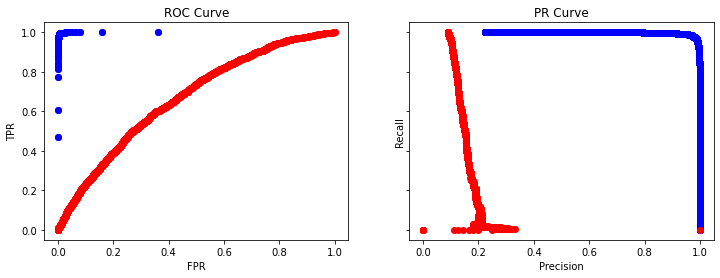

----- k = 5000 -----
Time elapsed (Training): 189.7706 s
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 10.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=5000,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
Accuracy (Training): 0.999976
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.656062
Time elapsed (Evaluation): 12.8405 s


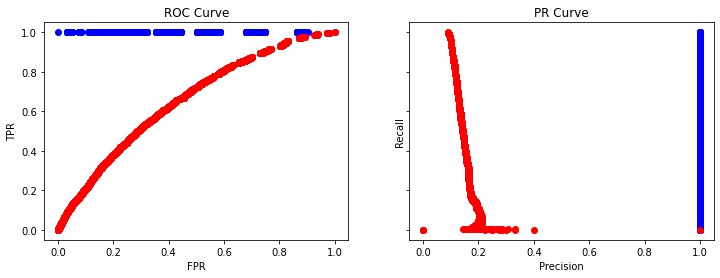

In [25]:
#max leaf Nodes
ks = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []

for k in ks:
    print('----- k = %d -----' % k)
    clf = ensemble.RandomForestClassifier(class_weight=class_weight, max_leaf_nodes=k)
    fit_time = train_model(clf, X_train, y_train)
    acc_score, rocauc_score,  eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score)

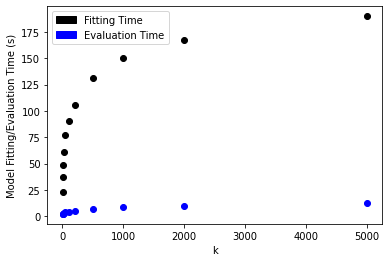

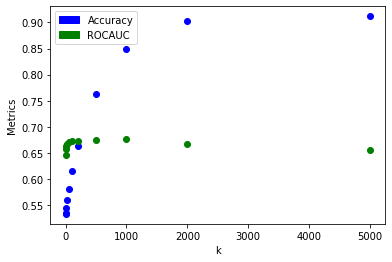

     0_k  1_Accuracy  2_ROCAUC  4_fit_time  5_eval_time
0      2    0.533397  0.646377   23.306938     2.217148
1      5    0.535956  0.657194   37.017849     2.384248
2     10    0.545248  0.663111   48.617669     2.591146
3     20    0.560891  0.666770   60.770703     2.806206
4     50    0.580801  0.671618   77.189019     3.910304
5    100    0.614885  0.673428   90.499977     4.469132
6    200    0.663238  0.673405  105.365134     5.205700
7    500    0.762361  0.675098  131.426855     6.848339
8   1000    0.849585  0.677361  150.099694     8.348157
9   2000    0.903342  0.667392  166.994032    10.154104
10  5000    0.911827  0.656062  189.770621    12.840525


               0_k  1_Accuracy   2_ROCAUC  4_fit_time  5_eval_time
count    11.000000   11.000000  11.000000   11.000000    11.000000
mean    807.909091    0.678321   0.666165   98.278045     5.615910
std    1520.629505    0.151025   0.009619   55.388636     3.538441
min       2.000000    0.533397   0.646377   23.306938     

In [26]:
plot_metrics(ks, 'k', False, fit_times, eval_times, acc_scores, rocauc_scores)